In [1]:
using CSV, DataFrames, Chain, Plots, StatsPlots, LaTeXStrings, DifferentialEquations
using Turing
using LazyArrays
using Random:seed!
using RecursiveArrayTools
seed!(123)

Random.TaskLocalRNG()

In [2]:
df = CSV.File("tuberculosis.csv") |> DataFrame

,Year,Case
,Int64,Int64
1,2020,7174
2,2019,8904
3,2018,9006
4,2017,9071
5,2016,9242
6,2015,9536
7,2014,9383
8,2013,9545
9,2012,9925


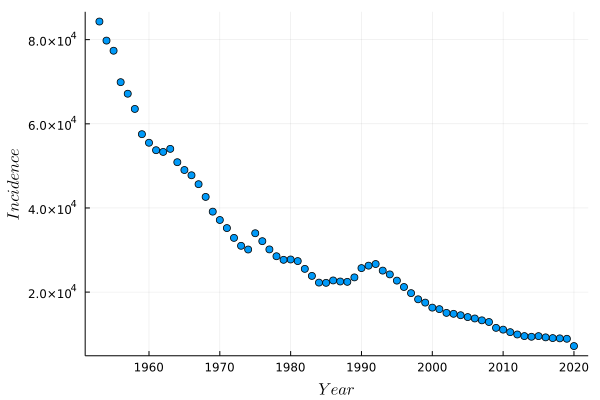

In [3]:
@df df scatter(:Year,
            :Case,
            xlab=L"Year", ylab=L"Incidence",
            #yformatter=y -> string(round(Int64, y ÷ 1_000)) * "K",
            label=false)

In [4]:
# Alternative Parameterization of Negative Binomial Distribution
function NegativeBinomial2(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ

    return NegativeBinomial(r, p)
end

NegativeBinomial2 (generic function with 1 method)

# Initial conditions

In [5]:
N = 160e6
i₀ = last(df[:, :Case])
Ti₀ = i₀ * 0.7
Tn₀ = i₀ * 0.3
L₀ = i₀ * 2.5
R₀ = i₀ * 2.5
u0 = [N - Ti₀ - Tn₀ - L₀ - R₀, L₀, Ti₀, Tn₀, R₀, i₀]
fixed_params = [3e6, 0.015]
τ, μT₀ = fixed_params

infected = df[end:-1:1,:Case]

68-element Vector{Int64}:
 84304
 79775
 77368
 69895
 67149
 63534
 57535
 55494
 53726
 53315
 54042
 50874
 49016
     ⋮
 11499
 11076
 10480
  9925
  9545
  9383
  9536
  9242
  9071
  9006
  8904
  7174

# Time-dependent model

In [6]:
function sir_TB(du, u, params, t)
    (S, L, Ti, Tn, R, tTB) = u
    (τ, μT₀, p, v, f, q, ω, c, AveI, b, Dᵦ, Dₘ, μ⁻) = params
    μ = 1/μ⁻
    β₀ = AveI*μ/τ
    

    @inbounds begin
        β = β₀/((1+b*Dᵦ*t)^(1/b))
        μT = μT₀/(1+ Dₘ*t)
        
        du[1] = τ - β*Ti*S - μ*S # dX/dt
        du[2] =  (1-p)*β*Ti*S - (v + μ)*L # dL/dt
        du[3] = p*f*β*Ti*S + q*v*L + ω*R - (μ + μT + c)*Ti # dTi/dt
        du[4] = p*(1-f)*β*Ti*S + (1-q)*v*L + ω*R - (μ + μT + c)*Tn # dTn/dt
        du[5] = c*(Ti + Tn) - (2*ω + μ)*R # dR/dt

        du[6] = p*β*Ti*S + v*L + 2*ω*R

    end
    nothing
end;



In [8]:
@model function bayes_TB(infected, u0)
    #calculate number of timepoints
    l = length(infected)

    τ = 3e6
    μT₀ = 0.015

    # priors
    μ⁻ ~ Uniform(60, 80)
    
    p ~ TriangularDist(0, 0.3, 0.05)
    v ~ Uniform(0.00256, 0.00527)
    f ~ TriangularDist(0.5, 0.85, 0.7)
    q ~ TriangularDist(0.5, 1, 0.85)
    ω ~ TriangularDist(0, 0.015, 0.005)
    c ~ TriangularDist(0.021, 0.086, 0.058)
    AveI ~ TriangularDist(0, 13, 1)
    
    b ~ Uniform(0, 1)
    Dᵦ ~ TruncatedNormal(0.5, 2, 1e-4, 10)
    Dₘ ~ TruncatedNormal(0.5, 2, 1e-4, 10)

    ϕ⁻ ~ truncated(Exponential(5), 0, 1e5)
    ϕ = 1.0 / ϕ⁻

    
    #ODE Stuff
    
    params = [τ, μT₀, p, v, f, q, ω, c, AveI, b, Dᵦ, Dₘ, μ⁻]
 
    tspan = (1.0, float(l))
    prob = ODEProblem(sir_TB,
            u0,
            tspan,
            params)
    sol = solve(prob,
                Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
                saveat=1.0)
    new_infected = Array(sol)[6, :] 
    sol = insert!(diff(new_infected), 1, new_infected[1])
    sol = max.(1e-4, sol) # numerical issues arose

    #likelihood
    infected ~ arraydist(LazyArray(@~ NegativeBinomial2.(sol, ϕ)))

end;



In [9]:

model_sir = bayes_TB(infected, u0)
chain_sir = sample(model_sir, NUTS(), MCMCThreads(), 2_000, 6)

┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\PC\.julia\packages\Turing\uMoX1\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\PC\.julia\packages\AdvancedHMC\w90s5\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\PC\.julia\packages\Turing\uMoX1\src\inference\hmc.jl:188
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\PC\.julia\packages\AdvancedHMC\w90s5\src\hamiltonian.jl:47
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\PC\.julia\packages\Turing\uMoX1\src\inference\hmc.jl:188
┌ Info: Found initial step size
│   ϵ = 0.05
└ @ Turing.Inference C:\Users\PC\.julia\packages\Turing\uMoX1\src\inference\hmc.jl:188
┌ Warning: The current proposal 

Chains MCMC chain (2000×24×6 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 6
Samples per chain = 2000
Wall duration     = 865.22 seconds
Compute duration  = 4564.54 seconds
parameters        = μ⁻, p, v, f, q, ω, c, AveI, b, Dᵦ, Dₘ, ϕ⁻
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          μ⁻   62.6033    2.5483     0.0233    0.0389   6336.4908    1.0036    ⋯
           p    0.2685    0.0186     0.0002    0.0002   7873.5831    1.0021    ⋯
           v    0.0034    0.0007     0.0000    0.0000   6443.7462    1.0010    ⋯
           f    0.6616    0.0639     0.0006    0.0010   7644.1597    1.0036    ⋯
           q    0.7671    0

In [10]:
# obtain 95% CrI of β₀
chain_sir_df = DataFrame(chain_sir)
beta0 = chain_sir_df.AveI ./(chain_sir_df.μ⁻ .*τ)
quantile(beta0, [0.025, 0.975])


2-element Vector{Float64}:
 3.598765298071698e-8
 6.714139551816306e-8

In [38]:
# Plot β(t) over time
summaries, quantiles = describe(chain_sir)
μ⁻, p, v, f, q, ω, c, AveI, b, Dᵦ, Dₘ,_  = summaries[:,:mean]
β₀ = AveI/(τ*μ⁻)
β = [β₀/((1 +b*Dᵦ*t)^(1/b)) for t in 1:length(infected)]

plotd = plot(xlabel=L"Year", ylabel=L"\beta(t)", legend=:topright)
plot!(df.Year[end:-1:1], β, label=L"\beta")
savefig(plotd, "beta.png")

In [39]:
# Plot μT(t) overtime
μT = [μT₀/(1+Dₘ*t) for t in 1:length(infected)]
plotd = plot(xlabel=L"Year", ylabel=L"\mu_T(t)", legend=:topright)
plot!(df.Year[end:-1:1], μT, label=L"\mu_T")
savefig(plotd, "muT.png")

In [40]:
μ = 1/μ⁻
Rf = (β*τ*μ)./(μ .+ μT .+ c) * p * f
Rs = (β*τ*μ)./(μ .+ μT .+ c) * (q*(1-p)*v/(v+μ))
Rr = (β*τ*μ)./((μ .+ μT .+ c).^2 .- (2*ω*c)/(2*ω + μ)) * (p + (1.0- p)*v/(v+μ)) * (ω*c/(2*ω + μ))
Rt = Rf .+ Rs .+ Rr
plotd = plot(xlabel=L"Year", ylabel=L"R(t)", legend=:topright)
plot!(df.Year[end:-1:1], Rt, label=L"R_t")
savefig(plotd, "Rt.png")

In [14]:
function sir_solve(param, u0, infected)
    prob = ODEProblem(sir_TB, u0, (1.0, float(length(infected))), param)
    sol = solve(prob,
            Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
            saveat=1.0)
    new_infected = Array(sol)[6, :] 
    sol = insert!(diff(new_infected), 1, new_infected[1])

    sol
end

function sir_pred_all(chain, fixed_params, u0, infected)
    params = DataFrame(chain)
    τ, μT = fixed_params
    #sols = []
    for i in 1:nrow(params)
        param_iter = params[i,:]
        _, _, μ⁻, p, v, f, q, ω, c, AveI, b, Dᵦ, Dₘ = param_iter
        
        param = [τ, μT₀,   p, v, f, q, ω, c, AveI, b, Dᵦ, Dₘ, μ⁻]
        
        solᵢ = sir_solve(param, u0, infected)
        
        #push!(sols, copy(solᵢ))
        if i == 1
            global sols = DataFrame(x = solᵢ)
        else
            sols = hcat(sols, solᵢ, makeunique=true)
        end
    end
    
    sols
end

sir_pred_all (generic function with 1 method)

In [15]:
fixed_params = [3e6, 0.015]
τ, μT₀ = fixed_params
summaries, quantiles = describe(chain_sir)
μ⁻, p, v, f, q, ω, c, AveI, b, Dᵦ, Dₘ,_  = summaries[:,:mean]


param = [τ, μT₀,   p, v, f, q, ω, c, AveI, b, Dᵦ, Dₘ, μ⁻]
sol_est = sir_solve(param, u0, infected)

68-element Vector{Float64}:
 84304.0
 64638.5498375936
 66067.56681404548
 65460.79184353058
 63897.589816639724
 61874.14737867564
 59642.10718658019
 57339.08201023645
 55039.49438624224
 52790.268731217715
 50614.80660586886
 48524.70410783612
 46528.669194082846
     ⋮
 11742.56535375258
 11473.346635563998
 11212.767016696278
 10960.34055657452
 10715.616456481162
 10478.309661327861
 10248.13511602697
 10024.807765490375
  9808.04255463113
  9597.554428360658
  9393.058331590379
  9194.26920923451

In [16]:
fixed_params = [3e6, 0.015]
pred = sir_pred_all(chain_sir, fixed_params, u0, infected)

A = Array(pred)
pred2 = [A[i, :] for i in 1:size(A,1)]
bounds = [quantile(v, [0.025, 0.975]) for v in pred2]
bounds1 = reduce(hcat, bounds)'


68×2 adjoint(::Matrix{Float64}) with eltype Float64:
 84304.0   84304.0
 58499.0   72545.5
 61294.4   73830.1
 61690.8   73180.5
 60896.8   71530.1
 59445.1   69406.1
 57746.7   66929.8
 55923.9   64292.9
 54015.2   61685.7
 52092.8   59167.5
 50171.0   56716.7
 48272.9   54374.0
 46453.5   52115.9
     ⋮     
 11998.9   13272.9
 11707.1   12986.4
 11423.5   12712.9
 11152.2   12444.6
 10887.8   12188.7
 10629.3   11934.5
 10379.4   11691.8
 10136.9   11455.6
  9903.09  11229.6
  9675.68  11008.7
  9454.53  10796.4
  9241.38  10585.4

In [41]:
bounds1 = reduce(hcat, bounds)'
pred_df = DataFrame(year = df[end:-1:1,:Year], mean = sol_est, lb = bounds1[:,1], ub = bounds1[:,2])
plotd = plot(xlabel=L"Year", ylabel=L"Incidence", legend=:topright)
plot!(df.Year, df.Case, label="data", seriestype=:scatter)
plot!(pred_df.year,pred_df.mean, label="model", linewidth=3,
        ribbon = (pred_df.lb, pred_df.ub))

savefig(plotd,"model2.png")

# Constant paramaters model

In [18]:
function sir_TB2(du, u, params, t)
    (S, L, Ti, Tn, R, tTB) = u
    (τ, μ⁻, p, v, f, q, ω, μT, c, AveI) = params
    μ = 1/μ⁻
    β = AveI*μ/τ
    @inbounds begin
        
        du[1] = τ - β*Ti*S - μ*S # dX/dt
        du[2] =  (1-p)*β*Ti*S - (v + μ)*L # dL/dt
        du[3] = p*f*β*Ti*S + q*v*L + ω*R - (μ + μT + c)*Ti # dTi/dt
        du[4] = p*(1-f)*β*Ti*S + (1-q)*v*L + ω*R - (μ + μT + c)*Tn # dTn/dt
        du[5] = c*(Ti + Tn) - (2*ω + μ)*R # dR/dt
        

        du[6] = p*β*Ti*S + v*L + 2*ω*R

    end
    nothing
end;

In [19]:
@model function bayes_TB2(infected, u0)
    #calculate number of timepoints
    l = length(infected)

    τ = 3e6
    μT = 0.015

    # priors 
    μ⁻ ~ Uniform(60, 80) 
    p ~ TriangularDist(0, 0.3, 0.05)
    v ~ Uniform(0.00256, 0.00527)
    f ~ TriangularDist(0.5, 0.85, 0.7)
    q ~ TriangularDist(0.5, 1, 0.85)
    ω ~ TriangularDist(0, 0.015, 0.005)
    c ~ TriangularDist(0.021, 0.086, 0.058)
    AveI ~ TriangularDist(0, 13, 7)
    ϕ⁻ ~ truncated(Exponential(5), 0, 1e5)
    ϕ = 1.0 / ϕ⁻
    

    #ODE Stuff
    param = [τ, μ⁻, p, v, f, q, ω, μT, c, AveI]
    tspan = (1.0, float(l))
    prob = ODEProblem(sir_TB2,
            u0,
            tspan,
            param)
    sol = solve(prob,
                Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
                saveat=1.0)
    new_infected = Array(sol)[6, :] 
    sol = insert!(diff(new_infected), 1, new_infected[1])
    sol = max.(1e-4, sol) # numerical issues arose

    #likelihood
    infected ~ arraydist(LazyArray(@~ NegativeBinomial2.(sol, ϕ)))

    μ = 1/μ⁻
    β = AveI*μ/τ
    

    Rf = (β*τ*μ)/(μ + μT + c) * p * f
    Rs = (β*τ*μ)/(μ + μT + c) * (q*(1-p)*v/(v+μ))
    Rr = (β*τ*μ)/((μ + μT + c)^2 - (2*ω*c)/(2*ω + μ)) * (p + (1.0- p)*v/(v+μ)) * (ω*c/(2*ω + μ))
    R0 = Rf + Rs + Rr

    return R0
end;

In [20]:
model_sir2 = bayes_TB2(infected, u0)
chain_sir2 = sample(model_sir2, NUTS(), MCMCThreads(), 2_000, 6)

┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\PC\.julia\packages\AdvancedHMC\w90s5\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\PC\.julia\packages\AdvancedHMC\w90s5\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\PC\.julia\packages\AdvancedHMC\w90s5\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\PC\.julia\packages\AdvancedHMC\w90s5\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false

Chains MCMC chain (2000×21×6 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 6
Samples per chain = 2000
Wall duration     = 96.3 seconds
Compute duration  = 562.93 seconds
parameters        = μ⁻, p, v, f, q, ω, c, AveI, ϕ⁻
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse          ess      rhat   ⋯
      Symbol   Float64   Float64    Float64   Float64      Float64   Float64   ⋯

          μ⁻   63.7189    3.7576     0.0343    0.0390    9310.2604    1.0000   ⋯
           p    0.2263    0.0406     0.0004    0.0006    4623.1389    1.0007   ⋯
           v    0.0035    0.0007     0.0000    0.0000   11746.6644    1.0001   ⋯
           f    0.5895    0.0589     0.0005    0.0006   10949.3481    0.9999   ⋯
           q    0.7096    0.1086     0.00

In [21]:
summaries, quantiles = describe(chain_sir2)
μ⁻, p, v, f, q, ω, c, AveI, ϕ⁻  = summaries[:,:mean]
β = AveI/(τ*μ⁻)

3.3321802622240727e-9

In [22]:
function sir_solve2(param, u0, infected)
    prob = ODEProblem(sir_TB2, u0, (1.0, float(length(infected))), param)
    sol = solve(prob,
            Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
            saveat=1.0)
    new_infected = Array(sol)[6, :] 
    sol = insert!(diff(new_infected), 1, new_infected[1])

    sol
end

function sir_pred_all2(chain, fixed_params, u0, infected)
    params = DataFrame(chain)
    τ, μT = fixed_params
    #sols = []
    for i in 1:nrow(params)
        param_iter = params[i,:]
        _, _, μ⁻, p, v, f, q, ω, c, AveI, _ = param_iter
        
        param = [τ, μ⁻, p, v, f, q, ω, μT, c, AveI]
        
        solᵢ = sir_solve2(param, u0, infected)
        
        #push!(sols, copy(solᵢ))
        if i == 1
            global sols = DataFrame(x = solᵢ)
        else
            sols = hcat(sols, solᵢ, makeunique=true)
        end
    end
    
    sols
end

sir_pred_all2 (generic function with 1 method)

In [31]:
# mean estimates

fixed_params = [3e6, 0.015]
τ, μT = fixed_params
summaries, quantiles = describe(chain_sir2)
μ⁻, p, v, f, q, ω, c, AveI = summaries[:,:mean]

param = [τ, μ⁻, p, v, f, q, ω, μT, c, AveI]
sol_est2 = sir_solve2(param, u0, infected)




68-element Vector{Float64}:
 84304.0
 13367.143108812554
 13561.18873854012
 13765.894002325804
 13981.113820498926
 14206.751525928441
 14442.730135089398
 14688.998392623209
 14945.558381349721
 15212.423858699942
 15489.62220526702
 15777.1962210348
 16075.246818213898
     ⋮
 43301.73671287997
 44375.41369787231
 45477.490457211854
 46608.62287812191
 47769.466847832315
 48960.67825356522
 50182.91298254742
 51436.872953556944
 52723.58265520772
 54043.71439433028
 55398.01597329904
 56787.276397834765

In [32]:
# 95% CrI
pred = sir_pred_all2(chain_sir2, fixed_params, u0, infected)

A = Array(pred)
pred2 = [A[i, :] for i in 1:size(A,1)]
bounds2 = [quantile(v, [0.025, 0.975]) for v in pred2]

68-element Vector{Vector{Float64}}:
 [84304.0, 84304.0]
 [11604.59884653773, 14661.014126580028]
 [11741.69834864856, 14876.32863742956]
 [11900.791735737483, 15100.502519116038]
 [12050.61977114348, 15346.742634349735]
 [12200.814113611075, 15611.407351669684]
 [12355.284187521122, 15894.03654694745]
 [12512.832555190267, 16197.465934718863]
 [12668.198091851178, 16504.849900005913]
 [12825.60705653063, 16826.123292723958]
 [12991.614757643996, 17183.467550203022]
 [13163.479243574606, 17568.373269443386]
 [13339.72958954453, 17963.488116202923]
 ⋮
 [26015.475985950063, 60057.911730875996]
 [26443.75307474486, 61907.35010971792]
 [26876.711708658084, 63803.57460135015]
 [27326.95657433407, 65817.0699664961]
 [27773.760014819265, 67798.94250852252]
 [28250.417590730493, 69857.63006128998]
 [28720.420160780108, 71999.13863385576]
 [29201.176088551514, 74241.92109389357]
 [29686.18966296746, 76505.90972191305]
 [30177.742647841682, 78842.42251669141]
 [30694.568777128472, 81261.146780393

In [34]:
R0 = generated_quantities(model_sir2, chain_sir2)
mean(R0[:])

┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL C:\Users\PC\.julia\packages\DynamicPPL\e6mZw\src\varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_hamiltonian_energy_error", "tree_depth", "numerical_error", "step_size", "nom_step_size"]
└ @ DynamicPPL C:\Users\PC\.julia\packages\DynamicPPL\e6mZw\src\varinfo.jl:1327
┌ Warning: the following keys were not found in `vi`, and thus `kernel!` was not applied to these: ["lp", "n_steps", "is_accept", "acceptance_rate", "log_density", "hamiltonian_energy", "hamiltonian_energy_error", "max_ham

0.0003090950110852516

In [33]:
bounds2 = reduce(hcat, bounds2)'
pred_df2 = DataFrame(year = df[end:-1:1,:Year], mean = sol_est2, lb = bounds2[:,1], ub = bounds2[:,2])
plotd = plot(xlabel=L"Year", ylabel=L"Incidence", legend=:topright)
plot!(df.Year, df.Case, label="data", seriestype=:scatter)
plot!(pred_df2.year,pred_df2.mean, label="model", linewidth=3,
        ribbon = (pred_df2.lb, pred_df2.ub))

savefig(plotd,"model1.png")